# Final Test Project

<b> Import the relevant libraries </b>

In [1]:
import pandas as pd 
import numpy as np 
import json 
 
%matplotlib inline 
import matplotlib.pyplot as plt 
 
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import RandomizedSearchCV, train_test_split 
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve

import warnings
warnings.filterwarnings('ignore')

<b> Read the breast-cancer-data.csv dataset </b>

In [2]:
df = pd.read_csv('breast-cancer-data.csv')
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,malignant


<b> Split the dataset into training and test sets </b>

In [3]:
X = df.drop(columns=['diagnosis'])
y = df['diagnosis'].values

In [4]:
for i in range(len(y)):
    if y[i] == 'malignant':
        y[i] = 1
    else:
        y[i] = 0

In [5]:
y = y.astype('int')

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(455, 30)
(455,)
(114, 30)
(114,)


<b> Choose a base model and define the range of hyperparameter values corresponding to the model to be searched for hyperparameter tuning </b>

In [7]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)

GradientBoostingClassifier()

In [8]:
param_dist = { 
    'n_estimators': list(range(10, 210, 10)), 
    'criterion': ['mae', 'mse'], 
    'max_features': ['sqrt', 'log2', 0.25, 0.3, 0.5, 0.8, None], 
    'max_depth': list(range(1, 10)), 
    'min_samples_leaf': list(range(1, 10)) 
}

<b> Define the parameters with which to initialize the RandomizedSearchCV object and use K-fold cross-validation to find the best model hyperparameters </b>

In [9]:
rand_search_params = { 
    'param_distributions': param_dist, 
    'scoring': 'accuracy', 
    'n_iter': 100, 
    'cv': 5, 
    'return_train_score': True, 
    'n_jobs': -1, 
    'random_state': 11 
}

In [10]:
random_search = RandomizedSearchCV(gbc, **rand_search_params) 
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['mae', 'mse'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8,
                                                      9],
                                        'max_features': ['sqrt', 'log2', 0.25,
                                                         0.3, 0.5, 0.8, None],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100, 110,
                                                         120, 130, 140, 150,
                                                         160, 170, 180, 190,
                                                         200]},
  

In [11]:
idx = np.argmax(random_search.cv_results_['mean_test_score']) 
final_params = random_search.cv_results_['params'][idx] 
final_params

{'n_estimators': 170,
 'min_samples_leaf': 6,
 'max_features': 0.3,
 'max_depth': 4,
 'criterion': 'mse'}

<b> Split the training dataset further into training and validation sets and train a new model using the final hyperparameters on the subdivided training dataset </b>

In [12]:
train_X, val_X, train_y, val_y = train_test_split(X_train, y_train, test_size=0.15)
print(train_X.shape)
print(val_X.shape)
print(train_y.shape)
print(val_y.shape)

(386, 30)
(69, 30)
(386,)
(69,)


In [13]:
gbc = GradientBoostingClassifier(**final_params) 
gbc.fit(train_X, train_y)

GradientBoostingClassifier(criterion='mse', max_depth=4, max_features=0.3,
                           min_samples_leaf=6, n_estimators=170)

<b> Calculate the accuracy, precision, and recall for predictions in relation to the validation set, and print the confusion matrix </b>

In [14]:
preds_train = gbc.predict(train_X)
preds_val = gbc.predict(val_X)
pred_probs_val = np.array([each[1] for each in gbc.predict_proba(val_X)])

In [15]:
print(f'train accuracy_score = {accuracy_score(y_true=train_y, y_pred=preds_train)}') 
print(f'validation accuracy_score = {accuracy_score(y_true=val_y, y_pred=preds_val)}') 
 
print(f'confusion_matrix: \n{confusion_matrix(y_true=val_y, y_pred=preds_val)}') 
print(f'precision_score = {precision_score(y_true=val_y, y_pred=preds_val)}') 
print(f'recall_score = {recall_score(y_true=val_y, y_pred=preds_val)}') 

train accuracy_score = 1.0
validation accuracy_score = 0.9855072463768116
confusion_matrix: 
[[34  1]
 [ 0 34]]
precision_score = 0.9714285714285714
recall_score = 1.0


<b> Experiment with varying thresholds to find the optimal point with high recall. Plot the precision-recall curve </b>

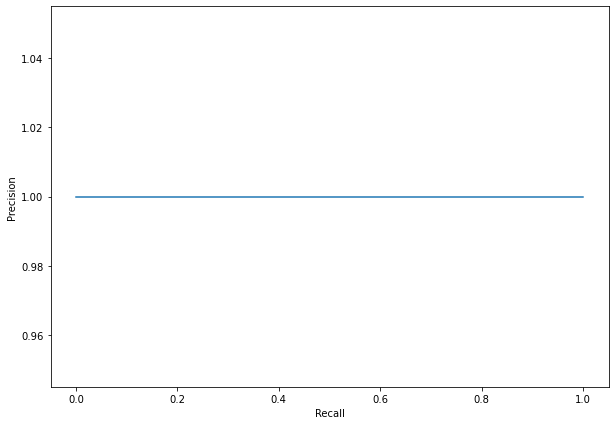

In [16]:
plt.figure(figsize=(10,7)) 
precision, recall, thresholds = precision_recall_curve(val_y, pred_probs_val) 
plt.plot(recall, precision) 
plt.xlabel('Recall') 
plt.ylabel('Precision') 
plt.show() 

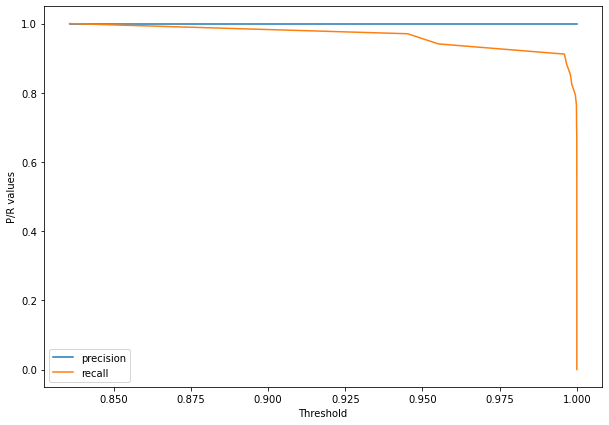

In [17]:
# Plot the variation in precision and recall with increasing threshold values.
PR_variation_df = pd.DataFrame({'precision': precision, 'recall': recall}, index=list(thresholds)+[1])
PR_variation_df.plot(figsize=(10,7))
plt.xlabel('Threshold')
plt.ylabel('P/R values')
plt.show()

<b> Finalize a threshold that will be used for predictions in relation to the test dataset </b>

In [18]:
final_threshold = 0.45

<b> Predict the final values on the test dataset </b>

In [19]:
pred_probs_test = np.array([each[1] for each in gbc.predict_proba(X_test)])
preds_test = (pred_probs_test > final_threshold).astype(int)
preds_test

array([0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0])

In [20]:
# saving in a csv file
with open('final_predictions.csv', 'w') as f:
    f.writelines([str(val)+'\n' for val in preds_test])